# Exercise 1
Try to build a classifier for the MNIST dataset that achieves over 97% accuracy
on the test set. Hint: the KNeighborsClassifier works quite well for this task;
you just need to find good hyperparameter values (try a grid search on the
weights and n_neighbors hyperparameters).

In [14]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

X, y = mnist.data, mnist.target

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] #dataset is already splitted at 60000 index
len(X_train), len(y_train), len(X_test), len(y_test), X_train.shape

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn_clf = KNeighborsClassifier(n_jobs=-1)

# base_score = cross_val_score(knn_clf, X_train, y_train, n_jobs=-1, scoring="accuracy")

# from sklearn.model_selection import GridSearchCV

# grid_params = [{
#     "n_neighbors": [2,3,4,5,6,7,8,9,10,50,100,200,1000,2000,4000,6000],
#     "weights": ["uniform", "distance"]
# }]

# knn_clf_grid_search = GridSearchCV(knn_clf, grid_params, n_jobs=5, cv=3, scoring="accuracy")
# knn_clf_grid_search.fit(X_train, y_train)

# knn_clf_grid_search.best_params_
# knn_clf = knn_clf_grid_search.best_estimator_

knn_clf = KNeighborsClassifier(n_neighbors=4, weights="distance")

knn_clf.fit(X_train, y_train)

cross_val_score(knn_clf, X_train, y_train, n_jobs=-1, scoring="accuracy", cv=5)

from sklearn.metrics import accuracy_score

y_preds = knn_clf.predict(X_test)
accuracy_score(y_test, y_preds)

0.9714

# Exercise 2
Write a function that can shift an MNIST image in any direction (left, right, up,
or down) by one pixel.6
 Then, for each image in the training set, create four
shifted copies (one per direction) and add them to the training set. Finally, train
your best model on this expanded training set and measure its accuracy on the
test set. You should observe that your model performs even better now! This
technique of artificially growing the training set is called data augmentation or
training set expansion.

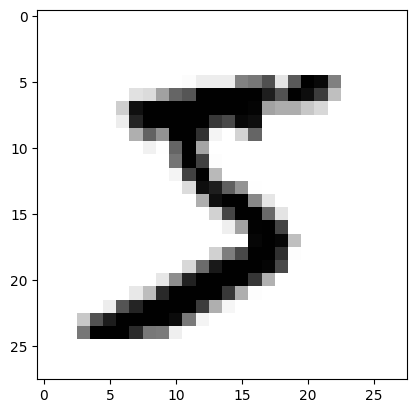

In [31]:
from scipy.ndimage._interpolation import shift
from matplotlib import pyplot as plt

def shift_image_one_pixel(image, direction):
    y, x = 0, 0 
    match direction:
        case "left":
            y, x = -1, 0
        case "right":
            y, x = 1, 0
        case "top":
            y, x = 0, 1
        case "down":
            y, x = 0, -1

    return shift(image, (x, y))

plt.imshow(shift_image_one_pixel(X_train[0].reshape(28,28), "left"), cmap="binary")

In [ ]:
import numpy as np

X_train_aug = X_train.copy()
y_train_aug = y_train.copy()

for idx, elem in enumerate(X_train):
    for direction in ("left", "right", "top", "down"):
        shifted_image =shift_image_one_pixel(elem.reshape(28,28), direction).reshape(784)
        X_train_aug = np.vstack((X_train_aug, shifted_image))
        y_train_aug = np.append(y_train_aug, y_train[idx])

In [ ]:
import numpy as np

X_train_aug = X_train.copy()
y_train_aug = y_train.copy()

for idx, elem in enumerate(X_train):
    for direction in ("left", "right", "top", "down"):
        shifted_image =shift_image_one_pixel(elem.reshape(28,28), direction).reshape(784)
        X_train_aug = np.vstack((X_train_aug, shifted_image))
        y_train_aug = np.append(y_train_aug, y_train[idx])

In [ ]:
len(X_train_aug), len(y_train_aug), len(X_train)

In [40]:
import numpy as np
from multiprocessing import Pool

def shift_and_augment(args):
    idx, elem, y = args
    augmented_samples = []
    for direction in ("left", "right", "top", "down"):
        shifted_image = shift_image_one_pixel(elem.reshape(28, 28), direction).reshape(784)
        augmented_samples.append((shifted_image, y))
    return augmented_samples

# Define the number of processes you want to run in parallel
num_processes = 4  # Adjust this according to your system's capabilities

# Create a pool of processes
pool = Pool(num_processes)

# Prepare arguments for parallel processing
args = [(idx, elem, y) for idx, (elem, y) in enumerate(zip(X_train, y_train))]

# Map the function to be parallelized to the arguments
augmented_results = pool.map(shift_and_augment, args)

# Close the pool to release resources
pool.close()
pool.join()

# Unpack the results into X_train_aug and y_train_aug
X_train_aug = np.vstack([sample[0] for result in augmented_results for sample in result])
y_train_aug = np.hstack([sample[1] for result in augmented_results for sample in result])


In [44]:
len(X_train_aug), len(y_train_aug)

240000

In [45]:
knn_clf.fit(X_train_aug, y_train_aug)

cross_val_score(knn_clf, X_train, y_train, n_jobs=-1, scoring="accuracy", cv=5)

from sklearn.metrics import accuracy_score

y_preds = knn_clf.predict(X_test)
accuracy_score(y_test, y_preds)

0.9743